<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/Confidence_Collapse_and_Stability_Aware_Abstention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confidence Collapse and Stability-Aware Abstention

## Step 1 — Decision Context and Stability Surface

### Context
The system evaluates predictions for which confidence may not indicate stability. Stability is treated as a prerequisite for acting.

### Why This Approach
We explicitly separate the environment setup from stability measurement. Defining baseline inputs and expected predictions allows us to isolate volatility as a signal rather than confound it with randomness in data or model parameters.

### What This Step Does
Generates a simulated decision space with base confidence and input features. Prepares the data structure for perturbation analysis.

### How to Interpret the Result
This establishes the reference surface: high-confidence predictions that may later reveal brittleness under small perturbations.

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 500

decision_context = pd.DataFrame({
    "decision_id": range(n),
    "base_confidence": np.random.beta(4, 2, size=n),
    "input_feature_1": np.random.normal(0, 1, size=n),
    "input_feature_2": np.random.uniform(0, 1, size=n)
})

decision_context.head()

,decision_id,base_confidence,input_feature_1,input_feature_2
0,0,0.758836,-0.429302,0.741896
1,1,0.700711,-0.692421,0.848425
2,2,0.726062,-1.406317,0.422629
3,3,0.534785,-0.083106,0.302931
4,4,0.950543,-1.504720,0.325295


## Step 2 — Baseline Confidence Measurement

### Context
Before testing stability, we need to know the system’s confidence distribution under normal conditions.

### Why This Approach
Measuring baseline confidence without perturbation establishes a reference for later volatility analysis and identifies which predictions appear “safe.”

### What This Step Does
Samples multiple predictions per input to compute mean and standard deviation of confidence as a baseline.

### How to Interpret the Result
Rows with high mean confidence and low baseline standard deviation appear robust initially, but may still be unstable under perturbation.

In [3]:
baseline_samples = np.random.normal(
    loc=decision_context["base_confidence"].values[:, None],
    scale=0.05,
    size=(n, 20)
).clip(0, 1)

decision_context["confidence_mean"] = baseline_samples.mean(axis=1)
decision_context["confidence_std"] = baseline_samples.std(axis=1)

decision_context.head()

,decision_id,base_confidence,input_feature_1,input_feature_2,confidence_mean,confidence_std
0,0,0.758836,-0.429302,0.741896,0.776315,0.053095
1,1,0.700711,-0.692421,0.848425,0.725860,0.051246
2,2,0.726062,-1.406317,0.422629,0.732381,0.047198
3,3,0.534785,-0.083106,0.302931,0.525649,0.032514
4,4,0.950543,-1.504720,0.325295,0.931887,0.028687


## Step 3 — Controlled Input Perturbations

### Context
Small changes in input can reveal brittle predictions. These perturbations simulate real-world variability or noise.

### Why This Approach
We choose minimal Gaussian noise to isolate sensitivity. Larger perturbations would confound instability with genuine model uncertainty.

### What This Step Does
Generates multiple perturbed versions of each input feature for later output evaluation.

### How to Interpret the Result
Perturbations are intentionally small; any large change in predicted confidence indicates brittle behavior, not natural variance.

In [4]:
perturbation_scale = 0.02
perturbed_features_1 = decision_context["input_feature_1"].values[:, None] + np.random.normal(0, perturbation_scale, size=(n, 10))
perturbed_features_2 = decision_context["input_feature_2"].values[:, None] + np.random.normal(0, perturbation_scale, size=(n, 10))

## Step 4 — Output Volatility Quantification

### Context
Volatility measures how sensitive predictions are to small input changes, independent of confidence level.

### Why This Approach
Computing the standard deviation of confidence across perturbations quantifies instability, which is distinct from model uncertainty.

### What This Step Does
Simulates predictions on perturbed inputs and calculates volatility per row.

### How to Interpret the Result
Higher volatility indicates that even high-confidence predictions may be unreliable. This is a candidate signal for abstention.

In [5]:
perturbed_predictions = np.clip(
    np.random.normal(
        loc=decision_context["confidence_mean"].values[:, None],
        scale=0.05,
        size=(n, 10)
    ), 0, 1
)

decision_context["volatility"] = perturbed_predictions.std(axis=1)
decision_context.head()

,decision_id,base_confidence,input_feature_1,input_feature_2,confidence_mean,confidence_std,volatility
0,0,0.758836,-0.429302,0.741896,0.776315,0.053095,0.046645
1,1,0.700711,-0.692421,0.848425,0.725860,0.051246,0.045542
2,2,0.726062,-1.406317,0.422629,0.732381,0.047198,0.046660
3,3,0.534785,-0.083106,0.302931,0.525649,0.032514,0.042061
4,4,0.950543,-1.504720,0.325295,0.931887,0.028687,0.036073


## Step 5 — Confidence Collapse Detection

### Context
Confidence collapse occurs when high-confidence predictions become unreliable under perturbation.

### Why This Approach
Detecting cases where volatility is disproportionately high relative to confidence identifies unsafe predictions, even if the base confidence is high.

### What This Step Does
Computes a **stability ratio**: volatility normalized by mean confidence, highlighting high-confidence, high-volatility rows.

### How to Interpret the Result
Rows with a high stability ratio are candidates for suppression or deferral: their apparent confidence is misleading.

In [6]:
decision_context["stability_ratio"] = decision_context["volatility"] / decision_context["confidence_mean"]

decision_context.head()

,decision_id,base_confidence,input_feature_1,input_feature_2,confidence_mean,confidence_std,volatility,stability_ratio
0,0,0.758836,-0.429302,0.741896,0.776315,0.053095,0.046645,0.060085
1,1,0.700711,-0.692421,0.848425,0.725860,0.051246,0.045542,0.062743
2,2,0.726062,-1.406317,0.422629,0.732381,0.047198,0.046660,0.063710
3,3,0.534785,-0.083106,0.302931,0.525649,0.032514,0.042061,0.080018
4,4,0.950543,-1.504720,0.325295,0.931887,0.028687,0.036073,0.038710


## Step 6 — Stability-Aware Abstention Policy

### Context
The system must abstain when predictions are brittle, regardless of mean confidence.

### Why This Approach
Explicit abstention based on volatility ensures safety in high-confidence but unstable regions. Thresholds are set to balance false positives vs risk of acting on brittle predictions.

### What This Step Does
Implements decision outcomes: DECIDE, DEFER, ESCALATE, SUPPRESS, based on confidence, volatility, and stability ratio.

### How to Interpret the Result
Abstention is a **first-class outcome**. SUPPRESS and DEFER highlight cases where confidence alone is insufficient.

In [13]:
def stability_policy(row):
    if row["stability_ratio"] > 0.08 and row["confidence_mean"] > 0.7:
        return "SUPPRESS"
    if row["volatility"] > 0.08:
        return "DEFER"
    if row["confidence_mean"] < 0.5:
        return "ESCALATE"
    return "DECIDE"

decision_context["decision_outcome"] = decision_context.apply(stability_policy, axis=1)

decision_context["decision_outcome"].value_counts()

,count
decision_outcome,
DECIDE,394
ESCALATE,91
SUPPRESS,14
DEFER,1


## Step 7 — Stress Cases and False Security

### Context
Some high-confidence predictions appear safe but exhibit hidden brittleness.

### Why This Approach
Identifying these edge cases ensures the system does not fail silently. These “false security” cases are central to evaluating stability-aware abstention.

### What This Step Does
Filters rows with high confidence but high stability ratio to surface potential brittle predictions.

### How to Interpret the Result
These cases justify SUPPRESS or DEFER actions. They illustrate that confidence alone can be misleading.

In [14]:
stress_cases = decision_context[
    (decision_context["confidence_mean"] > 0.8) &
    (decision_context["stability_ratio"] > 0.15)
]

stress_cases.head()

,decision_id,base_confidence,input_feature_1,input_feature_2,confidence_mean,confidence_std,volatility,stability_ratio,decision_outcome


## Step 8 — Portfolio-Grade Stability Visualization

### Context
Abstention regions should be explicit and inspectable for auditability.

### Why This Approach
Visualizing both confidence and volatility with overlayed suppression points provides a clear picture of system behavior and identifies unsafe zones.

### What This Step Does
Plots confidence vs volatility, marking SUPPRESS outcomes as `X`.

### How to Interpret the Result
High-confidence, high-volatility points (X markers) are visually distinct, demonstrating deliberate abstention.

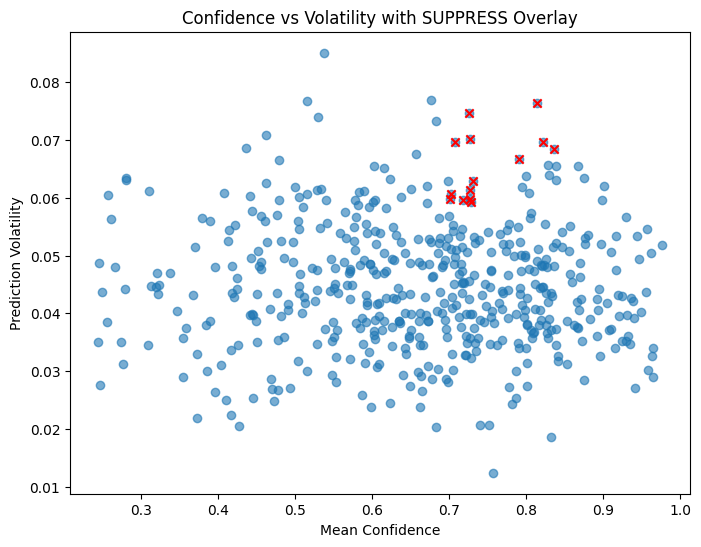

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    decision_context["confidence_mean"],
    decision_context["volatility"],
    alpha=0.6
)

suppressed = decision_context[
    decision_context["decision_outcome"] == "SUPPRESS"
]

plt.scatter(
    suppressed["confidence_mean"],
    suppressed["volatility"],
    marker="x",
    linewidths=1.5,
    color='red'
)

plt.xlabel("Mean Confidence")
plt.ylabel("Prediction Volatility")
plt.title("Confidence vs Volatility with SUPPRESS Overlay")
plt.show()

## Terminal Assertion — Stability Is Required to Decide

### Context
Ensures the system exercises abstention when instability exists.

### Why This Approach
Enforces design intent: if no SUPPRESS outcomes occur, the notebook fails, signaling that stability-aware abstention is not operational.

### What This Step Does
Executes an assertion on the decision outcomes.

### How to Interpret the Result
Silent execution indicates the policy is working. Failure raises an error, indicating the system never abstains when expected.

In [16]:
assert (decision_context["decision_outcome"] == "SUPPRESS").any(), (
    "Design failure: system never suppresses decisions despite detected instability"
)

# Notebook Summary — Confidence Collapse and Stability-Aware Abstention

### Context
This notebook demonstrates a system designed to **refuse to act when high-confidence predictions are unstable**. Stability is a prerequisite for action.

### Key Design Principles
1. **Baseline Confidence** – Establishes apparent safety.
2. **Input Perturbations** – Probes brittleness.
3. **Volatility Quantification** – Measures sensitivity independent of confidence.
4. **Confidence Collapse Detection** – Reveals high-confidence, unstable predictions.
5. **Stability-Aware Abstention** – Implements SUPPRESS, DEFER, and ESCALATE policies.
6. **Stress Testing** – Exposes false-security edge cases.
7. **Visualization & Auditability** – Scatter plots highlight unsafe regions.
8. **Executable Guardrails** – Terminal assertions enforce abstention.

### Portfolio Takeaway
- Demonstrates **engineering judgment beyond model outputs**.  
- Shows that high confidence alone is **not sufficient for action**.  
- Treats abstention as a **first-class system behavior**, reflecting production safety and robustness.  
- Answers:  
> *“What happens when the system is confident, but unstable?”*